<h1>TD1 Machine Learning - MMVAI</h1>
<h3>Yann Terrom</h3>

<p><strong>The goal of this parctical lab is to implement a decision tree classifier</strong></p>

<h2>Import</h2>

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from graphviz import Digraph

# This one are used to compare our decision tree with the one of sklearn-learn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

<h3>Generate and visualize the data</h3>

In [36]:
# Generate 200 2d feature points and their corresponding binary labels.
X = np.random.rand(200, 2)
y = np.zeros(200)
y[np.where(X[:,0]<X[:,1])] = 1

rows = np.column_stack((X, y))

In [37]:
# Create color maps
cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA'])
cmap_bold = ListedColormap(['#0000FF', '#FF0000'])

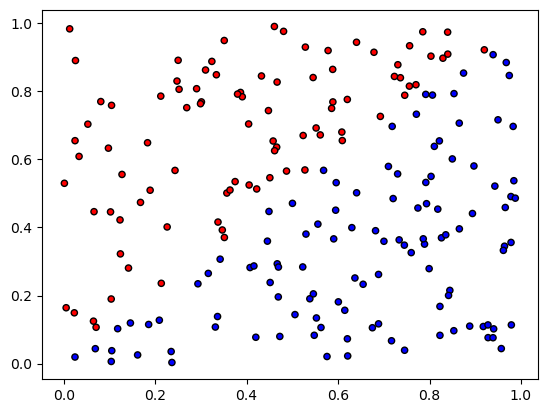

In [38]:
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)

<h3>TODO</h3>
<ul>
    <li>Write a python class called Question used to partition the dataset</li>
    <li>The training data could be seen as a table composed of 3 columns [X, Y] and 200 rows</li>
</ul>

In [39]:
class Question:
    """
    A Question is used to partition a dataset.
    """
    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        val = example[self.column]
        return val <= self.value

<ul>
    <li>For each row in the dataset, check if it matches the question. If so, add it to 'true rows', otherwise, add it to 'false rows'.</li>
</ul>

In [40]:
def split(rows, question):
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows


<ul>
    <li>Calculate the gini Impurity or the Entropy</li>
</p>

In [41]:
def class_counts(rows):
    """Counts the number of each type of example in a dataset."""
    counts = {} 
    for row in rows:
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [42]:
def gini(rows):
    """
    Calculates the Gini impurity for a set of rows.

    Parameters:
    - rows (list): A list of data rows where each row's last element is the class label.

    Returns:
    - float: The Gini impurity score for the set of rows.
    
    Formula:
    Gini impurity = 1 - Σ (p_i)^2

    where p_i is the probability of an item with label i in the set of rows.
    """
    counts = class_counts(rows)
    impurity = 1
    for label in counts:
        prob_of_label = counts[label] / float(len(rows))
        impurity -= prob_of_label ** 2
    return impurity


<ul> 
    <li>Compute the information gain as The uncertainty of the starting node, minus the weighted impurity of two child nodes.</li>
</ul>

In [43]:
def infomation_gain(left, right, current_uncertainty):
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

<ul> 
    <li>Find the best question to ask by iterating over every feature / value and calculating the information gain</li>
</ul>

In [44]:
def find_best_split(rows):
    best_gain = 0  
    best_question = None 
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1  

    for col in range(n_features): 
        values = set([row[col] for row in rows]) 

        for val in values:  
            question = Question(col, val)

            # try splitting the dataset
            true_rows, false_rows = split(rows, question)

            # Skip this split if it doesn't divide the
            # dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = infomation_gain(true_rows, false_rows, current_uncertainty)

            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question


<p><strong>Building the decision tree</strong></p>

In [45]:
def decision_tree(rows):
    gain, question = find_best_split(rows)

    # Stopping condition
    if gain == 0:
        return Leaf(rows)

    true_rows, false_rows = split(rows, question)

    # Recursively build the true branch.
    true_branch = decision_tree(true_rows)

    # Recursively build the false branch.
    false_branch = decision_tree(false_rows)

    # Return a Question node.
    return DecisionNode(question, true_branch, false_branch)

class Leaf:
    """A Leaf node classifies data."""

    def __init__(self, rows):
        self.predictions = class_counts(rows)

class DecisionNode:
    """A Decision Node asks a question."""

    def __init__(self, question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

<ul>
    <li>Define function to predict with the decision tree</li>
</ul>

In [46]:
def predict_single(node, row):
    """Predict the class label for a single row using the given decision tree."""
    # If we reach a leaf node, return the predictions
    if isinstance(node, Leaf):
        return max(node.predictions, key=node.predictions.get)

    # If the question is satisfied, go to the true branch; otherwise, go to the false branch
    if node.question.match(row):
        return predict_single(node.true_branch, row)
    else:
        return predict_single(node.false_branch, row)

def predict(tree, data):
    """Predict the class labels for a dataset using the given decision tree."""
    return [predict_single(tree, row) for row in data]

In [47]:
my_tree = decision_tree(rows)
my_predictions = predict(my_tree, X)

# Calculate accuracy using scikit-learn's accuracy_score
accuracy = accuracy_score(y, my_predictions)
print("Your decision tree accuracy:", accuracy)

# Compare with scikit-learn's decision tree

# Train scikit-learn's decision tree
sklearn_tree = DecisionTreeClassifier()
sklearn_tree.fit(X, y)

# Use scikit-learn's predict method
sklearn_predictions = sklearn_tree.predict(X)

# Calculate accuracy using scikit-learn's accuracy_score
sklearn_accuracy = accuracy_score(y, sklearn_predictions)
print("Scikit-learn decision tree accuracy:", sklearn_accuracy)

Your decision tree accuracy: 1.0
Scikit-learn decision tree accuracy: 1.0


In [56]:
def visualize_tree(node, dot=None, parent=None, edge_label=""):
    if dot is None:
        dot = Digraph(comment='The Decision Tree')

    if isinstance(node, Leaf):
        node_id = f'leaf_{node.predictions}_{id(node)}'
        
        if parent:
            dot.edge(parent, node_id, label=edge_label)
        return dot

    # Decision node
    question = node.question
    node_id = f'question_{question.column}_{id(node)}'
    dot.node(node_id, label=f'{feature_names[question.column]} <= {question.value}')
    if parent:
        dot.edge(parent, node_id, label=edge_label)

    # Recursive calls for true and false branches
    dot = visualize_tree(node.true_branch, dot, node_id, 'True')
    dot = visualize_tree(node.false_branch, dot, node_id, 'False')

    return dot

In [57]:
feature_names = ["Feature 1", "Feature 2"]

# Visualize the decision tree using graphviz
dot = visualize_tree(my_tree)
dot.render('decision_tree', format='png', cleanup=True)

'decision_tree.png'

<h3>Bonus</h3>

<p>Using sklearn the idea is to plot the decision boundaries and the also trying to visualize the decision tree (node and leaf)</p>

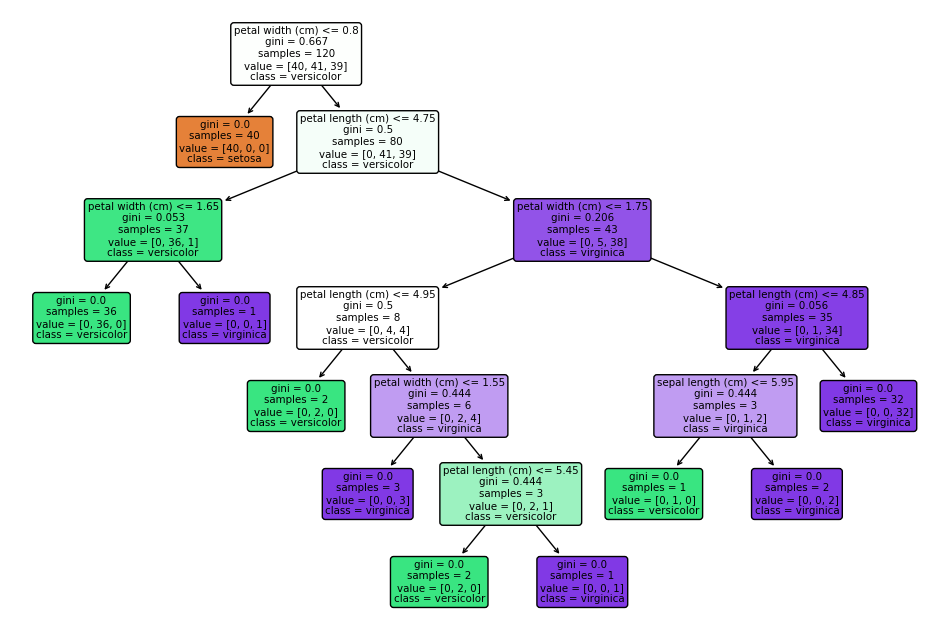

In [49]:
data = load_iris()
X = data.data
y = data.target

class_names = [str(cls) for cls in data.target_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier()

model.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
tree.plot_tree(model, filled=True, feature_names=data.feature_names, class_names=class_names, rounded=True)
plt.show()


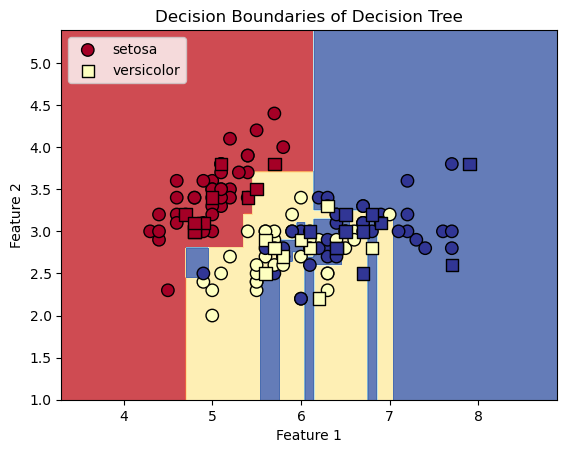

In [50]:
X = data.data[:, :2] 
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier()

model.fit(X_train, y_train)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

scatter_train = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.RdYlBu, marker='o', s=80, label='Training Data')
scatter_test = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.RdYlBu, marker='s', s=80, label='Testing Data')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundaries of Decision Tree')
plt.legend(handles=[scatter_train, scatter_test], labels=class_names, loc='upper left')

plt.show()
